In [2]:
!mkdir facades
!unzip archive\ \(2\).zip -d facades

mkdir: cannot create directory ‘facades’: File exists
Archive:  archive (2).zip
  inflating: facades/metadata.csv    
  inflating: facades/testA/1.jpg     
  inflating: facades/testA/10.jpg    
  inflating: facades/testA/100.jpg   
  inflating: facades/testA/101.jpg   
  inflating: facades/testA/102.jpg   
  inflating: facades/testA/103.jpg   
  inflating: facades/testA/104.jpg   
  inflating: facades/testA/105.jpg   
  inflating: facades/testA/106.jpg   
  inflating: facades/testA/11.jpg    
  inflating: facades/testA/12.jpg    
  inflating: facades/testA/13.jpg    
  inflating: facades/testA/14.jpg    
  inflating: facades/testA/15.jpg    
  inflating: facades/testA/16.jpg    
  inflating: facades/testA/17.jpg    
  inflating: facades/testA/18.jpg    
  inflating: facades/testA/19.jpg    
  inflating: facades/testA/2.jpg     
  inflating: facades/testA/20.jpg    
  inflating: facades/testA/21.jpg    
  inflating: facades/testA/22.jpg    
  inflating: facades/testA/23.jpg    
  inflat

In [1]:
%load_ext autoreload

In [18]:
%autoreload 2

from i2i.datasets.facades import FacadesDataset
from i2i.datasets.collator import Collator
from i2i.model.unet import UNet
from i2i.model.discriminator import Discriminator
from i2i.trainer.simple_trainer import train_epoch, evaluate, gan_train_epoch, log_images
from i2i.logger.wandb import WanDBWriter
from i2i.utils.utils import count_parameters
from i2i.utils.visualization import plot_batch_with_results
from i2i.loss.reconstruction import ReconstructionLoss
from i2i.loss.gan import GANLoss
from i2i.utils.visualization import plot_batch_with_results

In [3]:
import torch
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import OneCycleLR
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
import os

from itertools import repeat

In [28]:
config = dict(
    output_ch_size = 3,
    shape = (256,256),
    input_ch_size = 3,
    hidden_ch_size = 64,
    max_ch_num=512,
    feature_levels_num = 7,
    block_depth = 1,
    dropout_p=0.4,
    batch_size = 8,
    n_epochs = 100,
    discriminator_backprop_threshold = 0.7,
    generator_backprop_threshold = 0.7,
    max_steps=50,
    lr = 2e-4,
    overfit_batch = False,
    log_train_step=50,
    log_val_step=10,
    wandb_project = 'Image2Image',
    device = 'cuda:0'
)

In [5]:
dataset = FacadesDataset('facades/', split='train')
test_dataset = FacadesDataset('facades/', split='test')

collator = Collator()
train_loader = DataLoader(dataset, batch_size=config['batch_size'], collate_fn=collator, shuffle=True, drop_last=True, num_workers=6)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], collate_fn=collator, shuffle=True, num_workers=6)

model = UNet(**config)
model = model.to(config['device'])
discriminator = Discriminator(6, 64, 256, 2)
discriminator = discriminator.to(config['device'])

opt_G = torch.optim.Adam(model.parameters(), lr=config['lr'], betas=(0.5, 0.999))
# scheduler_G = OneCycleLR(opt_G, **{
#     "steps_per_epoch": len(train_loader),
#     "epochs": config['n_epochs'],
#     "anneal_strategy": "cos",
#     "max_lr": config['lr'] * 2,
#     "pct_start": 0.1
# })

opt_D = torch.optim.SGD(discriminator.parameters(), lr=config['lr'])
# scheduler_D = OneCycleLR(opt_D, **{
#     "steps_per_epoch": len(train_loader),
#     "epochs": config['n_epochs'],
#     "anneal_strategy": "cos",
#     "max_lr": config['lr'],
#     "pct_start": 0.1
# })

loss = GANLoss()

count_parameters(model), count_parameters(discriminator)

(29922185, 138689)

In [13]:
logger = WanDBWriter(config)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [7]:
if config['overfit_batch']:
    train_loader = iter(train_loader)
    batch = next(train_loader)
    train_loader = repeat(batch)

In [ ]:
for i in range(config['n_epochs']):
    gan_train_epoch(model, discriminator, opt_G, opt_D, train_loader, loss, config, logger=logger)
    
    metrics = evaluate(model, test_loader, config, loss.reconstruction_loss, logger=logger)
    
    for metric_name, metric_val in metrics.items():
        print(metric_name, np.mean(metric_val))
        
    batch = next(iter(test_loader))
    batch = batch.to('cuda:0')

    batch = model(batch)
    
    plot_batch_with_results(
        batch.sketch_images.detach().cpu(),
        batch.target_images.detach().cpu(),
        batch.predicted_image.detach().cpu()
    )
    
    if i % 500 == 0:
        torch.save({
            "model": model.state_dict(),
            "optimizer": opt_G.state_dict(),
            "discriminator": discriminator.state_dict(),
            "optimizer_D": opt_D.state_dict()
        }, f"model_epoch={i}")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

loss 0.19981138


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

loss 0.22373684


  0%|          | 0/50 [00:00<?, ?it/s]

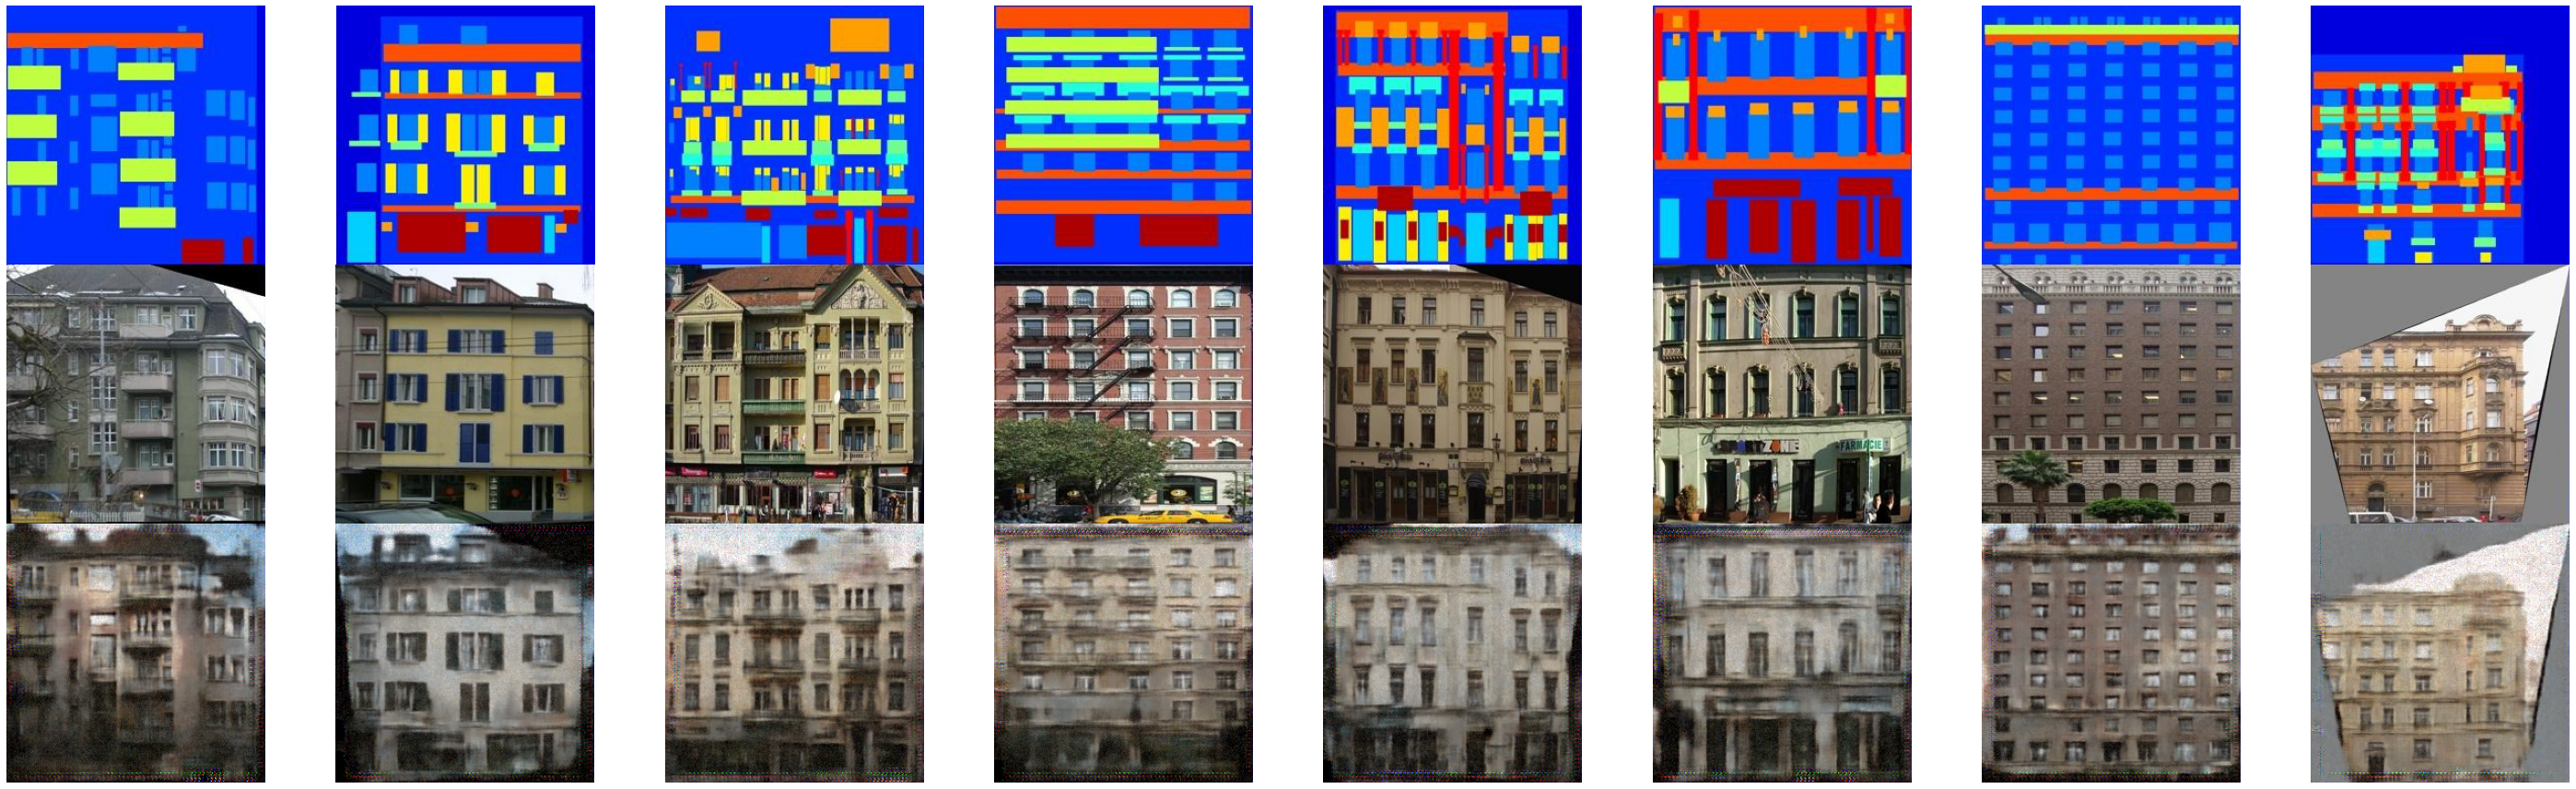

In [24]:
2+2

4

In [ ]:
for i in range(config['n_epochs']):
    train_epoch(model, opt, train_loader, loss, config, logger=logger)
    
    metrics = evaluate(model, test_loader, config, loss, logger=logger)
    
    for metric_name, metric_val in metrics.items():
        print(metric_name, np.mean(metric_val))
    
    if i % 200 == 0:
        torch.save({
            "model": model.state_dict(),
            "optimizer": opt.state_dict()
        }, f"model_epoch={i}")

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.22927472


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.14115547


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


loss 0.12580651


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.08999637


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.07228703


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.07041542


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.05712258


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.058931656


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.05596359


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.053507857


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.05164723


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.051309988


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


loss 0.049234357


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.049250636


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04922716


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.048365593


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.046785887


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04749436


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.047077853


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.047032498


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.047233388


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04676323


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error resolved after 0:00:23.364178, resuming normal operation.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04744711


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.046556067


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.045545917


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.045778427


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.046694282


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.046451446


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04569444


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.045941155


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.045939915


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04551241


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.046312764


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.0469701


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.045896538


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.046280243


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04520168


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.046262536


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.044935007


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04528377


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.045253366


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.046338305


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04606958


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04601355


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04542528


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error resolved after 0:00:23.543418, resuming normal operation.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04485257


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.044659495


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.046371493


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04624519


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.046533424


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04542233


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04585048


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.045871362


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

wandb: Network error resolved after 0:00:23.507494, resuming normal operation.


loss 0.046781596


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.0452341


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.0477863


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.046065185


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04459146


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.045134906


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04616424


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.046143085


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.045118943


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.046859782


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.049588755


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04523316


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.045475703


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.043941174


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.046432216


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.045384426


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.046336632


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error resolved after 0:00:23.764455, resuming normal operation.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.046077464


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.0450199


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04462497


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.045603864


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04473176


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.0457509


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.046699014


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04565248


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.047090713


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error resolved after 0:00:11.175193, resuming normal operation.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04603255


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04429274


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04480717


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04487348


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.045041833


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.045144897


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04702149


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.050560016


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04574707


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04524446


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.046091016


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04530658


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error resolved after 0:00:23.610731, resuming normal operation.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.049039755


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04910232


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.049658094


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.0445568


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04661827


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.046556402


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.047028337


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.046884034


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.049940877


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.050533574


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.047167834


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.046493158


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.050999187


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.046214417


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


loss 0.046393767


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error resolved after 0:00:11.159975, resuming normal operation.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.047460727


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.047512587


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error resolved after 0:00:11.293053, resuming normal operation.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04743785


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04697365


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.048270483


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error resolved after 0:00:11.202852, resuming normal operation.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.047492377


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04776488


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.049037192


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


loss 0.05022908


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.05400917


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.047539614


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04892981


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.051390395


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.047264475


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.048837885


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.049280424


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.048537344


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.048629317


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.048325524


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04890504


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.048465505


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.052064057


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.050643515


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04917905


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.048807543


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.051359717


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.046696614


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.052012876


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04803948


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.05160806


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.047583587


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.047867674


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.049549628


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.05294537


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.050257806


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.0506143


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.05554817


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error resolved after 0:00:11.261152, resuming normal operation.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04666257


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.048583005


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error resolved after 0:00:37.928387, resuming normal operation.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.051649366


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.049816325


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.051021848


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.048763547


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.048480812


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error resolved after 0:00:11.359642, resuming normal operation.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.051422175


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.05170951


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.048985694


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.050681256


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04928275


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.05115002


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error resolved after 0:00:11.212625, resuming normal operation.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.049695276


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04800399


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.051355805


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.050669793


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.049115233


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.049438767


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error resolved after 0:00:11.274071, resuming normal operation.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.05210252


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.049629025


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04998311


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04930699


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.05137712


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.05247312


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.0508437


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.04914176


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error resolved after 0:00:11.235344, resuming normal operation.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.050459832


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.052644975


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.051484387


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.054630104


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.051050495


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.050307043


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.049936358


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error resolved after 0:00:11.251767, resuming normal operation.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.051197212


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.051201895


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.051822606


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.050493207


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error resolved after 0:00:23.555779, resuming normal operation.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.052191474


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.050880007


  0%|          | 0/100 [00:00<?, ?it/s]

wandb: Network error resolved after 0:00:23.252327, resuming normal operation.


  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.0534978


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.051557805


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.05007458


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.05067356


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.05078186


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.052919332


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.05114193


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.05103946


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

loss 0.05062841


  0%|          | 0/100 [00:00<?, ?it/s]

In [14]:
torch.save({
    'model': model.state_dict(),
    'batch': batch
}, 'overfited_model.pth')

In [21]:
checkpoint = torch.load("overfited_model.pth", map_location='cpu')
model.load_state_dict(checkpoint['model'])
batch = checkpoint['batch']

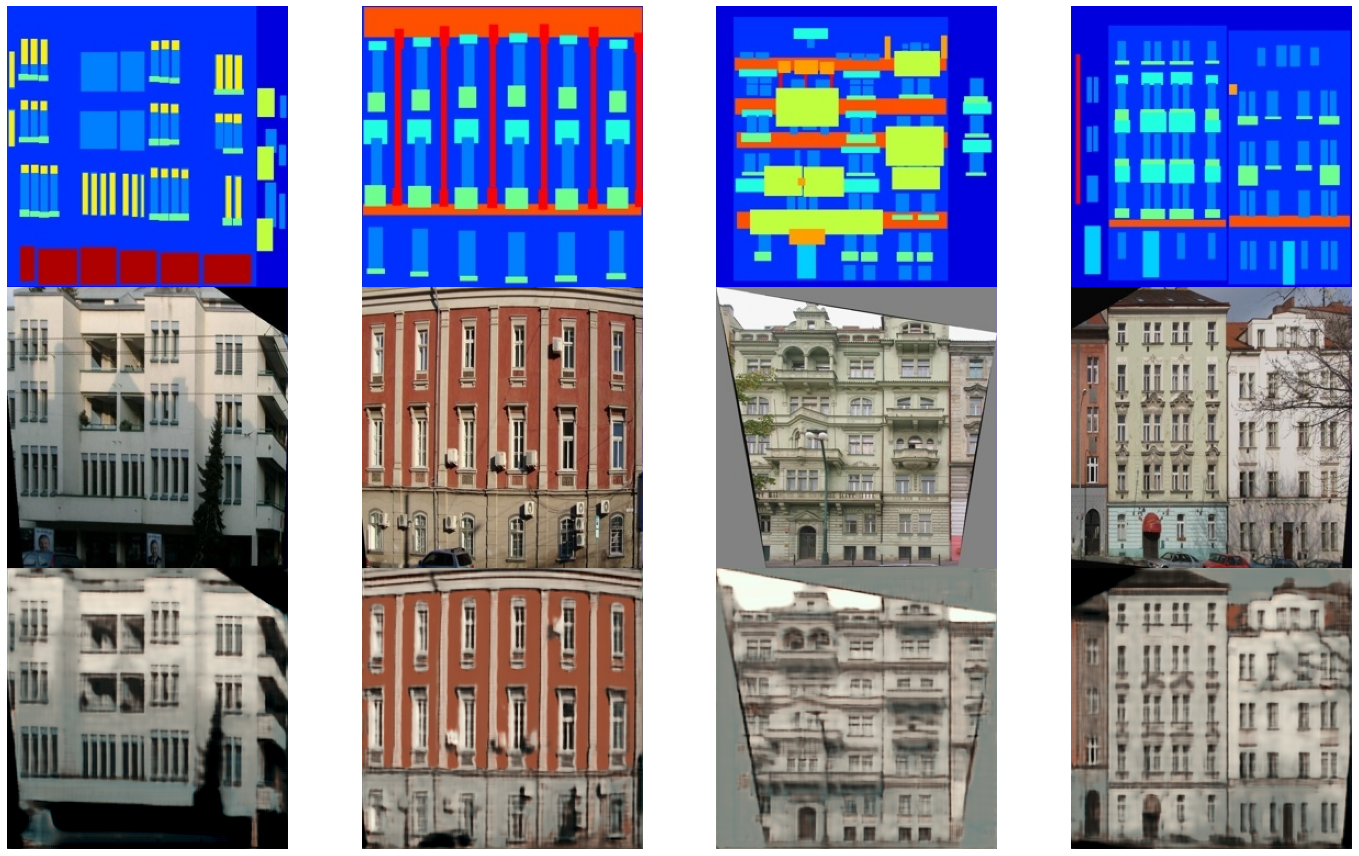

In [23]:
plot_batch_with_results(batch.sketch_images, batch.target_images, batch.predicted_image.detach().cpu())